In [1]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Text processing
import tensorflow as tf # conda install -c conda-forge tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Deep learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D #CNN specific

In [2]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection"
messages = pd.read_csv(url, sep ='\t', names=["label", "message"])
messages = messages.drop_duplicates()

#Oversampled + Original copy of spam
url2 = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/BacktranslatedSpam"
new_spam = pd.read_csv(url2, sep ='\t', names=["message"]) # No label like the usual file here
spam_labels = ["spam" for i in range(len(new_spam))]
new_spam.insert(0, "label", spam_labels, allow_duplicates=True)

In [3]:
ham_msg = messages[messages.label =='ham']
new_spam_df = new_spam.sample(n = len(ham_msg), random_state = 754)
msg_df = pd.concat([ham_msg, new_spam_df])
msg_df.reset_index(drop=True)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,ham,Even my brother is not like to speak with me. ...
...,...,...
9027,spam,"<Redirected from 21870000>Hello, this is your..."
9028,spam,don't know you and you don't know me. Send CH...
9029,spam,"You can stop more club tones by answering ""ST..."
9030,spam,"Latest news! Police station toilet stolen, po..."


In [4]:
msg_labels = (msg_df['label'].map({'ham': 0, 'spam': 1})).values
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],
                                                                  msg_labels,
                                                                  test_size=0.2,
                                                                  random_state=705)

In [5]:
#Tokenizer : turn words into integers
oov_tok = "<OOV>" # What to replace words that are not in the vocabulary with
vocab_size = 1000 # Maximum number of unique words for tokenizer

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level=False, # Work words by word
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [6]:
word_index = tokenizer.word_index

In [8]:
for word in word_index:
    if word_index[word] <= 5 or 995 <= word_index[word] < vocab_size:
        print(word, word_index[word])

<OOV> 1
to 2
you 3
a 4
the 5
pictures 995
nite 996
skilgme 997
run 998
star 999


**Word2Vec doesn't handle words that it doesn't have : just returns error**

In [9]:
embedd_dim = 100
model = Word2Vec(sentences=common_texts, vector_size=embedd_dim, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [10]:
vector = model.wv['computer']  # get numpy vector of a word
sims = model.wv.most_similar('computer', topn=10)  # get other similar words

In [11]:
# Deleting model when we no longer need to train, and only keeping the keys-vectors
word_vectors = model.wv
del model

In [12]:
word_vectors.key_to_index #This is a very small dataset to get a word2Vec

{'system': 0,
 'graph': 1,
 'trees': 2,
 'user': 3,
 'minors': 4,
 'eps': 5,
 'time': 6,
 'response': 7,
 'survey': 8,
 'computer': 9,
 'interface': 10,
 'human': 11}

# Creating model by myself
https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
The format for the input text is a list of sentence, where a sentence is a list of strings (one string = one word)

Main parameters of word2Vec :
- size: (default 100) Dimension of embedding space
- window: (default 5) Size of window for context
- min_count: (default 5) The minimum count of words to consider when training the model
- sg: (default 0 or CBOW) The training algorithm, either CBOW (0) or skip gram (1).

In [13]:
#example of formatting for word2vec input
sentences = [['this', 'is', 'the', 'first', 'sentence', 'for', 'word2vec'],
            ['this', 'is', 'the', 'second', 'sentence'],
            ['yet', 'another', 'sentence']]

In [14]:
converted = tokenizer.sequences_to_texts(tokenizer.texts_to_sequences(train_msg))
print(len(converted))
converted_test = tokenizer.sequences_to_texts(tokenizer.texts_to_sequences(test_msg))
print(len(converted_test))

7225
1807


In [15]:
print(converted[0]) #A single string
print(type(converted[0]))
print(converted[0].split()) #A list of words
print(type(converted[0].split()))

<OOV> £350 award today's voda numbers ending in <OOV> will be selected to receive a £350 award if you have a match call 08712300220 <OOV> claim code <OOV> standard rates <OOV>
<class 'str'>
['<OOV>', '£350', 'award', "today's", 'voda', 'numbers', 'ending', 'in', '<OOV>', 'will', 'be', 'selected', 'to', 'receive', 'a', '£350', 'award', 'if', 'you', 'have', 'a', 'match', 'call', '08712300220', '<OOV>', 'claim', 'code', '<OOV>', 'standard', 'rates', '<OOV>']
<class 'list'>


In [16]:
print(converted[7224].split()) # Number of words may be strictly less than 50

['but', 'your', 'not', 'here']


In [17]:
sentences_train = [converted[i].split() for i in range(len(converted))]
sentences_test = [converted_test[i].split() for i in range(len(converted_test))]

# Why use tokenizer if I can just split and use word2Vec immediately ?
- Tokenizer can handle out of vocabulary words by turning them to OOV token
- **Tokenizer removes punctuation, upper case letters**

I'm going to keep using the tokenizer method, another method would be use more text-cleaning methods (like remove numbers, urls,  word lemmazation and stemming to only keep roots of words)

In [18]:
embedd_dim = 32
model = Word2Vec(sentences=sentences_train, vector_size=embedd_dim, window=5, min_count=1, workers=4)
model.save("word2vec.model") #Can load models if they're really big, not the case here

In [19]:
word_vectors = model.wv
del model

In [21]:
print(len(word_vectors.key_to_index)) #999 words, need to add one more line for the filler token
word_vectors.key_to_index

999


{'<OOV>': 0,
 'to': 1,
 'you': 2,
 'a': 3,
 'the': 4,
 'i': 5,
 'your': 6,
 'call': 7,
 'and': 8,
 'for': 9,
 'is': 10,
 '2': 11,
 'free': 12,
 'now': 13,
 'in': 14,
 'on': 15,
 'of': 16,
 'or': 17,
 'have': 18,
 'u': 19,
 'from': 20,
 'text': 21,
 'me': 22,
 '4': 23,
 'with': 24,
 'get': 25,
 'are': 26,
 'stop': 27,
 'this': 28,
 'it': 29,
 'mobile': 30,
 'my': 31,
 'at': 32,
 'txt': 33,
 'be': 34,
 'will': 35,
 'only': 36,
 'just': 37,
 'send': 38,
 'prize': 39,
 'do': 40,
 'no': 41,
 'that': 42,
 'so': 43,
 'not': 44,
 'our': 45,
 'www': 46,
 'can': 47,
 'we': 48,
 '£': 49,
 'if': 50,
 '1': 51,
 'claim': 52,
 'ur': 53,
 'new': 54,
 'week': 55,
 'out': 56,
 "i'm": 57,
 'but': 58,
 'up': 59,
 'go': 60,
 'cash': 61,
 'phone': 62,
 'service': 63,
 'message': 64,
 '150p': 65,
 'want': 66,
 'all': 67,
 'reply': 68,
 'nokia': 69,
 'uk': 70,
 'by': 71,
 'as': 72,
 'won': 73,
 'number': 74,
 'win': 75,
 'been': 76,
 'who': 77,
 'what': 78,
 'contact': 79,
 'time': 80,
 'like': 81,
 'know': 8

# Visualize word embedder

Word2Vec allows us to find most similar word to a list of given ones

In [22]:
result = word_vectors.most_similar(positive=['free'])
most_similar_key, similarity = result[0]

print(most_similar_key, similarity)

phones 0.9042706489562988


In [39]:
vocab = list(word_vectors.key_to_index)
word_matrix = word_vectors[vocab]
print(word_matrix.shape)

(999, 32)


In [40]:
# Adding the row corresponding to the filler token
if word_matrix.shape[0] != vocab_size:
    word_matrix = np.vstack([np.zeros(embedd_dim), word_matrix])
    print(word_matrix.shape)
    print(word_matrix[0])

(1000, 32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [41]:
from sklearn.manifold import TSNE

In [42]:
word_matrix_TSNE15 = TSNE(n_components=2, learning_rate='auto',
                     perplexity=15., init='random').fit_transform(word_matrix)

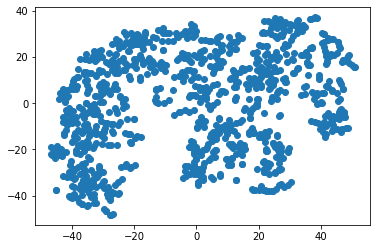

In [43]:
fix, ax = plt.subplots()
ax.scatter(word_matrix_TSNE15[:,0], word_matrix_TSNE15[:,1])

# Keras model

In [44]:
# Sequencing and padding on training and testing 
max_len = 50 # Max number of tokens, used with truncating and padding
trunc_type = "post" # Truncates sequences of tokens that are longer than max_len, post=right side
padding_type = "post" # Pads AFTER (with post) if sequence is shorter than max_len

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               padding = padding_type, truncating = trunc_type)

In [45]:
#F1 score is not defined in Keras
#From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
from tensorflow.keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [47]:
#vocab_size = 1000
#max_len = 50
#embedd_dim = 32

conv1_size = 32
conv2_size = 48
fc1_size = 48
dropout_rate1 = 0.2
fc2_size = 24
dropout_rate2 = 0.3

batch_size = 20

In [61]:
CNN2 = Sequential()
CNN2.add(Embedding(vocab_size, embedd_dim, input_length=max_len,
                  weights=[word_matrix],
                   trainable=True))
CNN2.add(Conv1D(conv1_size, 3, activation='relu'))
CNN2.add(MaxPooling1D(pool_size=2))
CNN2.add(Conv1D(conv2_size, 3, activation='relu'))
CNN2.add(MaxPooling1D(pool_size=2))
CNN2.add(Flatten())
CNN2.add(Dropout(dropout_rate1))
CNN2.add(Dense(fc1_size, activation='relu'))
CNN2.add(Dropout(dropout_rate2))
CNN2.add(Dense(fc2_size, activation='relu'))
CNN2.add(Dense(1, activation='sigmoid'))
CNN2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])
CNN2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 32)            32000     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 32)            3104      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 22, 48)            4656      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 11, 48)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 528)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 528)              

In [62]:
histCNN2 = CNN2.fit(training_padded, train_labels,
                    validation_data=(testing_padded, test_labels),
                    epochs=15, batch_size=batch_size)

Epoch 1/15
362/362 [==============================] - 3s 5ms/step - loss: 0.1924 - accuracy: 0.9283 - precision_m: 0.9412 - recall_m: 0.9259 - f1_m: 0.9273 - val_loss: 0.1153 - val_accuracy: 0.9618 - val_precision_m: 0.9913 - val_recall_m: 0.9365 - val_f1_m: 0.9604
Epoch 2/15
362/362 [==============================] - 2s 4ms/step - loss: 0.0998 - accuracy: 0.9683 - precision_m: 0.9764 - recall_m: 0.9578 - f1_m: 0.9652 - val_loss: 0.0790 - val_accuracy: 0.9740 - val_precision_m: 0.9963 - val_recall_m: 0.9553 - val_f1_m: 0.9741
Epoch 3/15
362/362 [==============================] - 2s 4ms/step - loss: 0.0588 - accuracy: 0.9795 - precision_m: 0.9849 - recall_m: 0.9748 - f1_m: 0.9787 - val_loss: 0.0494 - val_accuracy: 0.9834 - val_precision_m: 0.9874 - val_recall_m: 0.9816 - val_f1_m: 0.9837
Epoch 4/15
362/362 [==============================] - 2s 4ms/step - loss: 0.0429 - accuracy: 0.9845 - precision_m: 0.9874 - recall_m: 0.9818 - f1_m: 0.9836 - val_loss: 0.0816 - val_accuracy: 0.9762 - va

In [65]:
loss, accuracy, precision, recall, f1_score = CNN2.evaluate(testing_padded, test_labels, verbose=0)
print(accuracy, precision, recall, f1_score)

0.9889319539070129 0.9975772500038147 0.9797483086585999 0.9882700443267822


# Result evaluation
Using Word2Vec without being able to train the weights leads to fairly poor results.

Giving the model the ability to train the weights learned from word2Vec performs better, but not really better than using our initial, more naive, word embedder.
The only change using word2Vec makes is the initialization of the weights of the different words.

In [55]:
word_confidence = np.zeros((vocab_size+1, 2))

confidence_train = CNN2.predict(training_padded, batch_size=32) #Much much faster than observation by observatio
L = training_padded.shape[0]
for i in range(L):
    for token in training_padded[i]:
        word_confidence[token, 0] += confidence_train[i]
        word_confidence[token, 1] += 1
            
confidence_test = CNN2.predict(testing_padded, batch_size=32)
L = testing_padded.shape[0]
for i in range(L):
    for token in testing_padded[i]:
        word_confidence[token, 0] += confidence_test[i]
        word_confidence[token, 1] += 1

In [56]:
word_color = np.zeros(vocab_size)
for i in range(vocab_size):
    if word_confidence[i, 1] == 0.0:
        print("Should never happen")
        word_color[i] = 0.5 #Neutral
    else:
        word_color[i] = word_confidence[i,0] / word_confidence[i,1]
print(word_color.shape)

(1000,)


In [58]:
embed_layer = CNN2.get_layer(CNN2.layers[0].name)
embedding = embed_layer.get_weights()
embedding = embedding[0]

In [59]:
embeddingTSNE15 = TSNE(n_components=2, learning_rate='auto',
                     perplexity=15.0, init='random').fit_transform(embedding)

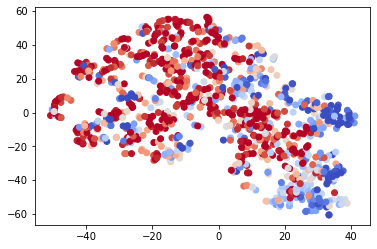

In [60]:
plt.scatter(embeddingTSNE15[:,0], embeddingTSNE15[:,1], c=word_color, cmap='coolwarm')
#coolwarm colormap : red = 1 (spam), blue = 0 (ham)
plt.show()